In [5]:
%matplotlib inline

FairLearn Project with Synthetic Credit Card Approval Data
==========================================================


This notebook shows how to use Fairlearn to generate predictors for the
Synthetic Credit Card Approval dataset. This dataset is a classification problem - given a range of data about 500,000 individuals, predict whether the individual is approved or not for a credit card.

We will use the data to train a predictor to predict whether previously unseen individuals will
be given a credit card or not. The assumption is that the model predictions are
used to decide whether an individual should be offered a credit card.

We will first train a fairness-unaware predictor and show that it leads
to unfair decisions under a specific notion of fairness called
*demographic parity*. We then mitigate unfairness by applying the
`GridSearch`{.sourceCode} algorithm from the Fairlearn package.

Below the source code used to build the core of the exercise: https://fairlearn.org/v0.7.0/auto_examples/plot_grid_search_census.html#sphx-glr-auto-examples-plot-grid-search-census-py

DataSet Size:
500000 rows × 6 columns

Load and preprocess the data set
================================




In [6]:
pip install extendeddataframeteamc==0.2

Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.model_selection import train_test_split
from fairlearn.reductions import GridSearch
from fairlearn.metrics import *
from fairlearn.reductions import DemographicParity, ErrorRate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import pandas as pd
import fairdetect_group_c as fdc
import groupc_extended_df as xdf

In [8]:
data = pd.read_csv('synthetic_credit_card_approval.csv')
data.head()

,Num_Children,Group,Income,Own_Car,Own_Housing,Target
0,4,0,36151,0,0,0
1,0,0,36095,1,0,0
2,2,1,62110,1,1,0
3,0,1,73644,1,0,0
4,3,0,99146,0,0,1


DataSet columns order by the original dataset:
- `Num_Children`: the total number of children 
- `Group`: column clasifies the applicant into two groups (`0` or `1`).    
- `Income`: the total income of each applicant 
- `Own_Car`: Owning or not a car (`1` the applicant owns a car, `0` doesn't own a car).
- `Own_Housing`: Owning or not a hourse (`1` the applicant owns a house, `0` doesn't own a house).
- `Target`: Got approved or not for a credit card (`1` the applicant was approved for a credit card, `0` was rejected for a credit card).

Below we will instanciate the raw dataset and the Y target

In [9]:
X_raw = data
Y = data["Target"]

In this example we will use __"the selected feature by the user"__ as the sensitive feature.(0 and 1 meaning explain above). Therefore, this variable will be drop from the initial dataset. 

In [10]:
# selecting the feature for the exercise. We can include this in a function. 
choice = input("Select the Sensitive Feature: \n A) Num_Children. B) Group. C) Own_Car. D) Own_Housing. [A-B-C-D]? : ").upper()
if choice == "A":
    sensitive = 'Num_Children'
    print("\n The sensitive feature selected is: %s" %sensitive)
elif choice == "B":
    sensitive = 'Group'
    print("\n The sensitive feature selected is: %s" %sensitive)
elif choice == "C":
    sensitive = 'Own_Car'
    print("\n The sensitive feature selected is: %s" %sensitive)
elif choice == "D":
    sensitive = 'Own_Housing'
    print("\n The sensitive feature selected is: %s" %sensitive)


Select the Sensitive Feature: 
 A) Num_Children. B) Group. C) Own_Car. D) Own_Housing. [A-B-C-D]? : C

 The sensitive feature selected is: Own_Car


In [11]:
sensitive_feature = X_raw[sensitive]
A = sensitive_feature #temprary dataset to sto
X = X_raw.drop(labels=['Target'], axis=1)

#READ ME: Should we scale for this exercise. if so we have to do the same in rayans notbook to have a fair comparison.
#sc = StandardScaler()
#X_scaled = sc.fit_transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

Here, we will split the dataset to train the model

In [12]:
X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(X,
                                                                     Y,
                                                                     A,
                                                                     test_size=0.2,
                                                                     random_state=0,
                                                                     stratify=Y)

# Work around indexing bug
X_train = X_train.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

Training a fairness-unaware predictor
=====================================

To show the effect of Fairlearn we will first train a standard ML
predictor that does not incorporate fairness. 
we use the following model
`xgboost.XGBClassifier`


In [13]:
import xgboost

unmitigated_model =  xgboost.XGBClassifier()
unmitigated_model.fit(X_train, Y_train)
y_pred=unmitigated_model.predict(X_test)

Here we will evaluate the unmitigated model score. In this example we can conclude there is a high overfiting as the score is extremly closed to the 1. The porpuse of this exercise is not the model, but to undrestand disparitties in the user selected group, therefore we will not deep further on feature engeniring. 

In [14]:
unmitigated_model.score(X_test, Y_test)

0.97284

## Fairlearn in a Nutshell

As an overview of Fairlear, there are two components of the library:

1. Metrics to assess model unfrainess to specific groups, and for compering multiple models in terms of fairness and accuracy
2. Algorithms for mitigating unfairness

Fairlearn has a fairness-related metrics that can be contrasted amoung sensitive features or for the overall population. The most powerfull resources from Fairlearn is that expands metrics definitions from *scikit-learn*. 

source: https://fairlearn.org/v0.7.0/quickstart.html

## Fairlearn Pipeline

The is a tool to assess AI systems' fairness and mitigate any observed fairness issue. This fairness tool provides to developers of AI with a pipeline to ensure AI systems are developed under a framework of unfariness. 

### Pipeline

1. **Fairness Assessment:** 
    Farilearn provides a module of fairness related metrics that can be applied fo any kind of model than the business uses, but also can be used to validate the results of the mitigating techniques delovep based on the Mitigating section.  
    1.1 **Type of Metrics:** for more details go to https://fairlearn.org/main/user_guide/assessment.html
        1.1.1 Ungrouped Metrics
        1.1.2 Metrics with Grouping
        1.1.3 Scalar Results from MetricFrame
        1.1.4 Control features for grouped metrics
        1.1.5 Plotting grouped metrics


2. **Mitigation:** 
    Farilearn provides a module of mitigation tha aims to produce a fair model for all the groups and for the overall model. Fairlearn contains different algorithms that can be used depending the problem to be resolved. Please find below a matix of available models and their used in AI systems', and for more detal go to https://fairlearn.org/v0.7.0/user_guide/mitigation.html

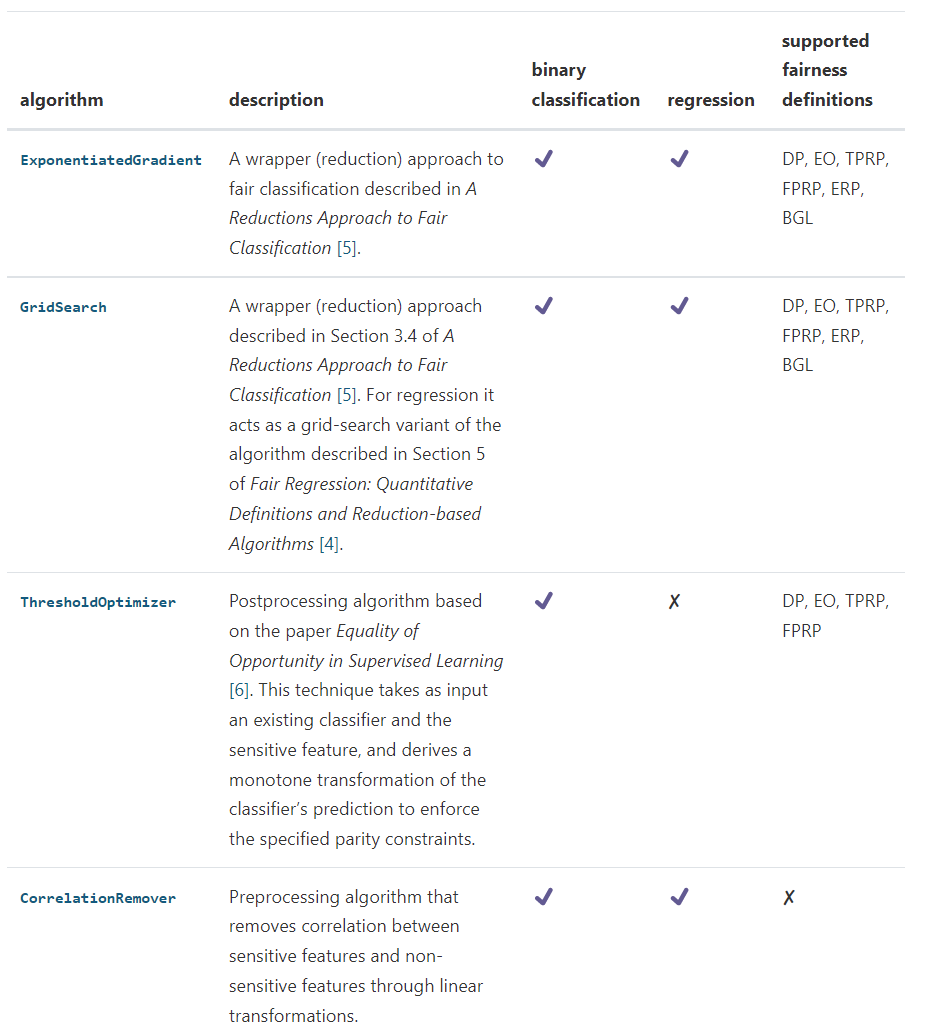



## Fairness Assesment 

As describe above we will follow the Fairlearn piple starting from the fariness assesment using the metric framework provided in the library. 

### MetricFrame 

MetricFrame is a collection of disagregated value metrics. In syntesis, the MetricFrame compute an individual or set of metrics to the entire population and by group with the main objective to identify disparities among the data and the sensitive groups. 

In our example, we have used `MetricFrame` with the following metrics *TPR, FPR,TNR,FPR, Selection rate, Accuracy and Count*. As an inout we have provided the sample of the sensitive feature, target and a prediction. In order to asses disparities in  the syntetic card data

In [15]:
metric_frame = MetricFrame(metrics={"true positive rate": true_positive_rate,
                                    "false positive rate": false_positive_rate,
                                    "true negative rate": true_negative_rate,
                                    "false negative rate":  false_negative_rate,
                                    "accuracy": accuracy_score,
                                    "selection_rate": selection_rate,
                                    "count": count
                                    },
                           sensitive_features=A_test,
                           y_true=Y_test,
                           y_pred=y_pred)


A `MetricFrame` returns a MetricFrame object but when calling a method the return is a series that can be transformed in a pandas dataframe to see the data in a more organized way. Bellow we will explore the metrics results for the overall dataset by calling a method named `metricframe.overall` to display all metric in a `pandas df` 

In [16]:
df_mf = pd.DataFrame(metric_frame.overall)
df_mf.columns =['Overall']
df_mf

,Overall
true positive rate,0.965859
false positive rate,0.02276
true negative rate,0.97724
false negative rate,0.034141
accuracy,0.97284
selection_rate,0.38739
count,100000


The most powerfull resource from `MetricFrame` is the availity to assess the metrics for all the groups to make a comparison in terms of fairness of the results given. Bellow in our example we are using the method `by_group` to display the result per each of the values for the selected sensitive feature to dientify unfairness within the group. 

In [17]:
pd.DataFrame(metric_frame.by_group)

,true positive rate,false positive rate,true negative rate,false negative rate,accuracy,selection_rate,count
Own_Car,,,,,,,
0,0.949853,0.017984,0.982016,0.050147,0.972551,0.292215,30019
1,0.970599,0.025279,0.974721,0.029401,0.972964,0.428216,69981


As a result of the analysis, with fairlearn we can have a very comprenhasive and detail analysis of the model unfairness by group using a plots to compare metrics per each of the groups. In the following example. We can see that FN and FP there is a clear difference between both groups (having or not having a car), similar disparities found in the selection rate giving a benefit to those who own a car over those that doesn't. 

array([[<AxesSubplot:title={'center':'true positive rate'}, xlabel='Own_Car'>,
        <AxesSubplot:title={'center':'false positive rate'}, xlabel='Own_Car'>,
        <AxesSubplot:title={'center':'true negative rate'}, xlabel='Own_Car'>,
        <AxesSubplot:title={'center':'false negative rate'}, xlabel='Own_Car'>],
       [<AxesSubplot:title={'center':'accuracy'}, xlabel='Own_Car'>,
        <AxesSubplot:title={'center':'selection_rate'}, xlabel='Own_Car'>,
        <AxesSubplot:title={'center':'count'}, xlabel='Own_Car'>,
        <AxesSubplot:xlabel='Own_Car'>]], dtype=object)

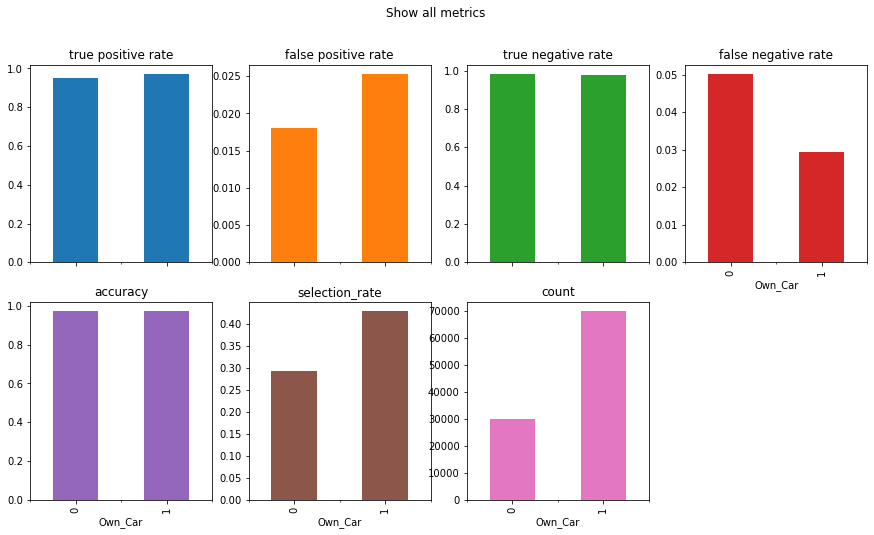

In [18]:
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[2, 4],
    legend=False,
    figsize=[15, 8],
    title="Show all metrics",
)

If we compared this with fairdetect library from Rayan's we can find a list of differences for his original model in which his approach is to show a representation of the overall model in which he measures if there is a relation between the target and the sensitive variable. This can be explored within fairnlearn but is more generic approach where the end user builds his own analysis, compare to a much more structure and standard view that Ryan's offers in his library. 

And addition to that, Rayan's explore the surface of disparities by group, however his model can only hands 4 metrics from a confusion matrix. In comparison, fairlearn extending sklearn can reproduce similar comparison with n number of metrics, providing more flexibility to the user. 

As a result of this project, we have expanded in Rayan's code the possibility to read more than  4 metrics to make it much more flexible, all of this can be explore in more detail from the docstrings. 

Finaly, rayans compares the predictions from one group and another. Yet, the most significant difference is that Rayan's does a chi square test to assess statistically the disparity and this is not explore or display in fairlearn as a possibility 

## Ryan's Report 

Below a view of Fairdetect library created by Rayan

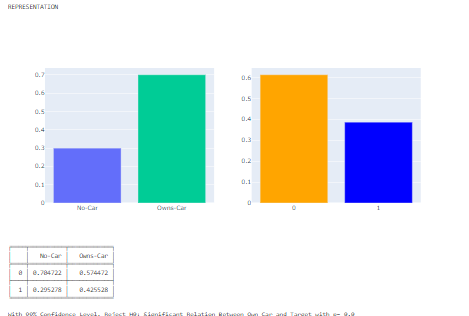

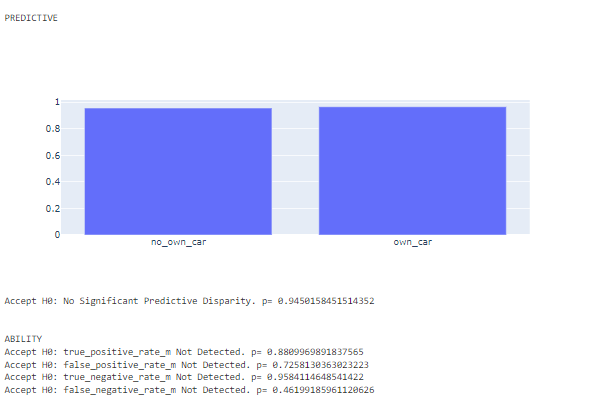

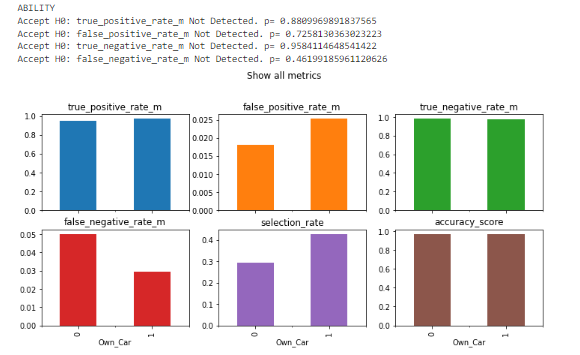


## Comparison Matrix


Please find below a very comprenhensive comparison matrix to assess the differences in the models. 

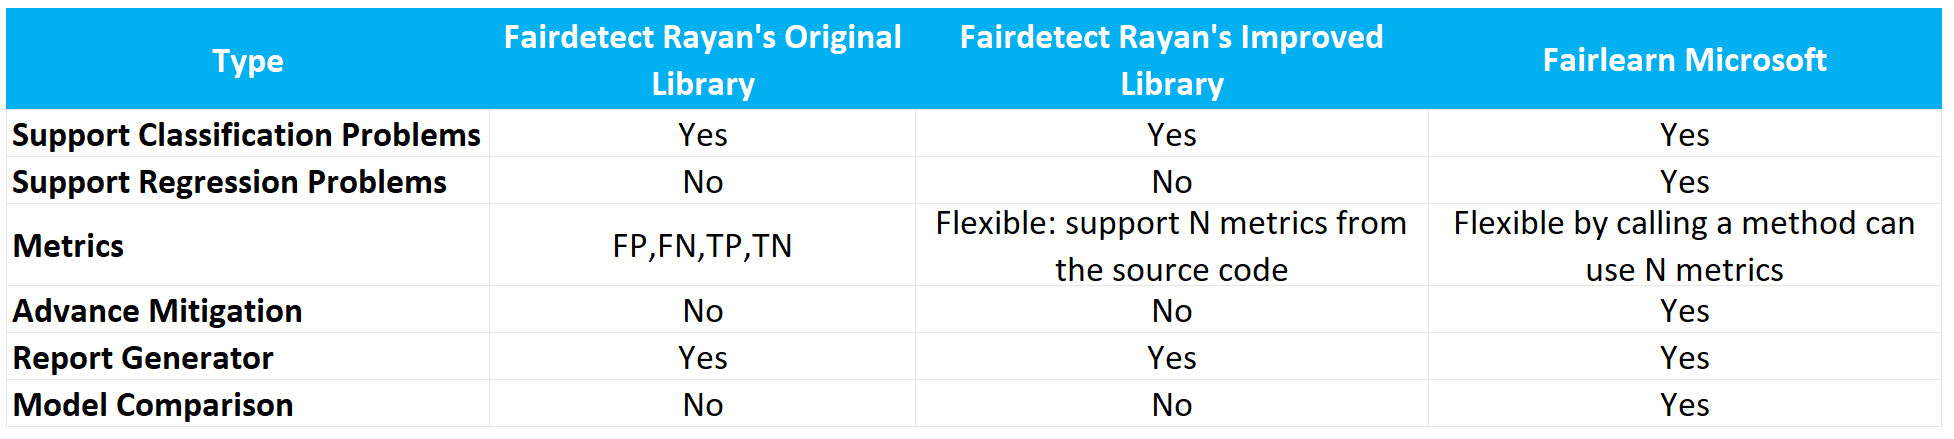


## Comparison Conclusion

As a conclusion Rayan's is a very detail well structure model to assess disparity in a dataset. However, microsoft developed a flexible a roboust pipeline not only to assess but to mitigate unfairness in AI models. I would recomend enhacement on Rayan based on solving fairness problems in machine learning models and also expand to resolve othe type of models as regression. 


Mitigation with GridSearch
==========================

The `fairlearn.reductions.GridSearch`{.interpreted-text role="class"}
class implements a simplified version of the exponentiated gradient
reduction of [Agarwal et al. 2018](https://arxiv.org/abs/1803.02453).
The user supplies a standard ML estimator, which is treated as a
blackbox. [GridSearch]{.title-ref} works by generating a sequence of
relabellings and reweightings, and trains a predictor for each.



In [19]:
sweep = GridSearch(unmitigated_model,
                   constraints=DemographicParity(),
                   grid_size=71)

In [ ]:
sweep.fit(X_train, Y_train,
          sensitive_features=A_train)

predictors = sweep.predictors_

C:\Users\Nuria Vivero\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
C:\Users\Nuria Vivero\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
C:\Users\Nuria Vivero\anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be r

In [ ]:
errors, disparities = [], []
for m in predictors:
    def classifier(X): return m.predict(X)

    error = ErrorRate()
    error.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)
    disparity = DemographicParity()
    disparity.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame({"predictor": predictors, "error": errors, "disparity": disparities})

non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][all_results["disparity"] <= row.disparity]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)

Bellow there is an evaluation of the dominant models along with unmitigated model explore from the begining of the exercice

In [ ]:
predictions = {"unmitigated": unmitigated_model.predict(X_test)}
metric_frames = {"unmitigated": metric_frame}
for i in range(len(non_dominated)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated[i].predict(X_test)
    metric_frames[key] = MetricFrame(metrics={"accuracy": accuracy_score,
                                              "selection_rate": selection_rate,
                                              "count": count},
                                     sensitive_features=A_test,
                                     y_true=Y_test,
                                     y_pred=predictions[key])
import matplotlib.pyplot as plt
x = [metric_frame.overall['accuracy'] for metric_frame in metric_frames.values()]
y = [metric_frame.difference()['selection_rate'] for metric_frame in metric_frames.values()]
keys = list(metric_frames.keys())
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i] + 0.0003, y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")

Above we used an mdoel for fairlearn to mitigate unfairness in the model and this is the most powerfull feature as it resolve the bias in the data and provide a more fair AI systems. 